## Latent Personal Analysis in Python
by Uri Alon and Alex Abbey

This short tutorial will demonstrate how to use the Python implementation of LPA, as described in the [article](https://link.springer.com/article/10.1007/s11257-021-09295-7) in User Modeling and User-Adapted Interaction.

LPA helps analyze a corpus of text, or any set of data, by taking into account the missing popular elements and frequently used yet generally infrequent elements.

The first implementation for LPA was written by Hagit Ben-Shoshan in SQL and can be found [here](https://github.com/hagitbenshoshan/text_distance/) - 
For very large datasets, users of this package are encouraged to switch to the SQL implementation using cloud infrustructure, as the calculation of the results will be much faster.

Dependencies can be found in `requirements.txt`.

### Terminology

It can be useful to think of the basic unit of analysis as a word, which is part of a chapter, which is part of a book. To keep things general we'll use these terms:
* **Element** is the basic unit of analysis, i.e. a word
* **Categories** (or entities or documents) are compared to each other and in the context of their domain.**Local weight** is the normalized frequency of elements whithin a category. Each weighted entity's vector is termed Personal Vector Rates (**PVR**). 
* **Domain** (or world or corpus) consist of all of the categories, and is what the categories are compared to. The weighted domain vector is termed Domain Vector Rates (**DVR**).


In [1]:
import pandas as pd
from LPA import LPA

In this tutorial we demonstrate LPA using a small portion of the LOCO dataset (Miani, 2021), the unprocessed data available here: https://osf.io/snpcg/. The data you are using should consist of a count of elements per category. For instance, with this dataset, each category is an article, each element is a (tokenized) word, and the frequency is a count of the amount of times the word appeared in an article. The input should be a csv file with the columns: `element`, `category`, `frequency_in_category`. 

In [3]:
df = pd.read_csv('./frequency.csv')
display(df.head())
display(df.describe(include="all"))

,category,element,frequency_in_category
0,C00001,know,4.0
1,C00001,associ,5.0
2,C00001,said,1.0
3,C00001,known,3.0
4,C00001,colonel,1.0


,category,element,frequency_in_category
count,350874,350869,350874.000000
unique,1000,24709,NaN
top,C0029e,one,NaN
freq,2047,727,NaN
mean,NaN,NaN,1.829950
std,NaN,NaN,2.434249
min,NaN,NaN,1.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,2.000000


#### Creating the domain
The domain (DVR) consists of the frequency of all elements from all categories together. Use the head and tail of the `dvr` to calibrate your epsilon.

In [4]:
dvr = LPA.create_dvr(df)
display(dvr.head())
display(dvr.tail())

,element,frequency_in_category,global_weight
0,one,3023.0,0.004708
1,peopl,2981.0,0.004643
2,us,2763.0,0.004303
3,world,2728.0,0.004249
4,use,2476.0,0.003856


,element,frequency_in_category,global_weight
24704,kultur,1.0,0.000002
24705,kung,1.0,0.000002
24706,kushcyyenko,1.0,0.000002
24707,kutless,1.0,0.000002
24708,在,1.0,0.000002


#### Creating an instance of `LPA`
To create an instance of the `LPA` object you must create a `dvr`, either by creating it ahead of time and loading it from a file, or by using the static method `create_dvr`. Epsilon is set to 1 / (domain size * `epsilon_frac`), where if `epsilon_frac` is a number greater than 1 will decrease the weight of epsilon (the default weight given to missing terms) while a number between 0 and 1 will increase it. By default `epsilon_frac` is set to 2.

In [6]:
# pick epsilon
epsilon_frac=2
1/(len(dvr)*epsilon_frac) 

2.0235541705451456e-05

In [7]:
lpa = LPA(dvr, epsilon_frac=epsilon_frac)

#### Creating Signatures
Another prominent use of LPA is creating a signature for every category, which is made up of the most meaningful terms for every category, whether in their prominence or absence. Usually, one won't need the full signature, but rather signatures of a certain length, as shown in the paper. To create signatures you can use the explicit process:
1. Create distances with `create_distances()`. This will give you a DataFrame with $KLD_\varepsilon$ distnaces (which are all positive, regardless of if they are over- or under-used) of all of the words in the corpus for each category (in alphabetical order).
2. Using the distances DataFrame create signatures with `add_underused()` which adds the "underused" column. `True` signifies the element is used less within the category (locally) than globally in the DVR, and `False` means the opposite.
3. Cut the signatures to the preferred length with `cut()`. `sig_length` defaults to 500.

Conversely, use the `create_and_cut()` function which does all three at once.

In [12]:
distances = lpa.create_distances(df)
sigs = lpa.add_underused(distances)
sigs = lpa.cut(sigs, sig_length=500)
sigs

,category,element,KL,underused
0,C00001,aquino,0.053742,False
1,C00001,abus,0.021800,False
2,C00001,michael,0.017277,False
3,C00001,new,0.017213,True
4,C00001,victim,0.014125,False
...,...,...,...,...
499995,C004c4,becam,0.001422,True
499996,C004c4,central,0.001416,True
499997,C004c4,final,0.001416,True
499998,C004c4,simpli,0.001416,True


To get a feel for the dataset as a whole, check the the distance of each category from the domain by computing the summed distance of the signature from the `dvr`. 

<AxesSubplot:ylabel='Frequency'>

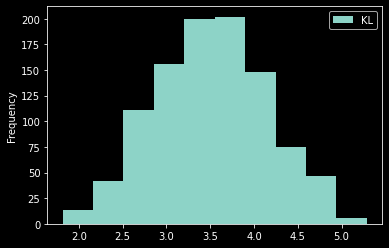

In [16]:
distances = lpa.create_distances(df)
distances.groupby("category").sum().plot.hist()
# lpa.distance_summary(df).head()

#### Distances between pairs of categories (Sockpuppet Distance)
Finally, one can use the signatures created to calculate the L1 distance between every pair of categories. 
`sockpuppet_distance` accepts two DataFrames of $n$ and $m$ signatures respectively and compares them, returning a matrix sized $n \times m$. Different signature lengths and epsilons can have dramatic effects on the results.

In [13]:
lpa.sockpuppet_distance(signatures1=sigs.iloc[:5000], signatures2=sigs.iloc[:5000])

func: sockpuppet_distance took: 0:00:00.153046


category,C00001,C00003,C00004,C00005,C00007,C00008,C00009,C0000a,C0000b,C0000c
category,,,,,,,,,,
C00001,0.000000,2.757313,2.242467,1.517752,2.655146,2.481741,1.875268,2.315507,3.112205,2.193046
C00003,2.757313,0.000000,2.699781,2.860203,2.875945,2.760948,2.618410,2.701495,3.132657,2.691435
C00004,2.242467,2.699781,0.000000,2.287605,2.410529,2.430894,2.037306,2.364594,2.784505,2.134203
C00005,1.517752,2.860203,2.287605,0.000000,2.765364,2.519797,2.020111,2.381801,3.218368,2.241575
C00007,2.655146,2.875945,2.410529,2.765364,0.000000,2.545261,2.363791,2.668364,2.816953,2.258325
C00008,2.481741,2.760948,2.430894,2.519797,2.545261,0.000000,2.223212,2.463562,2.954522,2.373065
C00009,1.875268,2.618410,2.037306,2.020111,2.363791,2.223212,0.000000,2.243098,2.837591,1.972219
C0000a,2.315507,2.701495,2.364594,2.381801,2.668364,2.463562,2.243098,0.000000,3.025728,2.377948
C0000b,3.112205,3.132657,2.784505,3.218368,2.816953,2.954522,2.837591,3.025728,0.000000,2.736792


### Further analysis
Once we have calculated the distances between every category, we can perform further analysis on the results, for instance by clustering the sockpuppet distances and finding similar categories. 

## Good Luck!

### References
Miani, A., Hills, T. & Bangerter, A. LOCO: The 88-million-word language of conspiracy corpus. Behav Res (2021). https://doi.org/10.3758/s13428-021-01698-z

Mokryn, O., Ben-Shoshan, H. Domain-based Latent Personal Analysis and its use for impersonation detection in social media. User Model User-Adap Inter 31, 785–828 (2021). https://doi.org/10.1007/s11257-021-09295-7